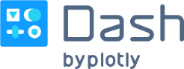
## **EDA ⇒ 特徴量選択 ⇒ 決定木 ：機械学習による自動実行**
データセットから重要な特徴量を選び、シンプルな決定木を描くまでを自動化したものです。\
アップロードしたデータセットの可視化、最低限の前処理、特徴量選択、決定木分析を自動実行します。

<details><summary>概要説明 :</summary><div>

- 問題発生時の原因の糸口をつかむ等、目的変数に影響する特徴量をできるだけ簡単に見い出すことを目的としています。（モデルの精度向上は意図していません。)
- 回帰（Regression）・分類（Classification）データのいずれも実行可能です。
- 前処理は、決定木分析を前提に割り切ったものとしています。各前処理項目は実行を任意に選択できます。
- データ可視化はDataPrep、特徴量選択はBuruta-SHAP、決定木はdtreevizを用いています。
- **結果に影響する重要な特徴量を選び、その上で特徴量と結果のつながりを決定木で示します**ので、**どのようなケースが結果に影響しているかが掴みやすくなるはず**です。原因特定に近づく一助になることを願いますが、正常に動作しなかったり、エラーが出たら、ごめんなさい。


<details><summary>動作説明 :</summary><div>

###**前準備: データセット（csvデータ）の表形式は以下としてください**
- **<font color= "Crimson">目的変数 は 最右端に配置**</font>してください。
- [**注意**] csvデータは文字コードを「UTF-8」としてください。

|データ項目1|データ項目2|データ項目3|…|結果項目（目的変数）|
|---|---|---|---|---|
|○○|△▼|□■|…|□★○|
|○●|△△|□□|…|○○★|
|○○|▲▼|■■|…|●▲★|


### **実行手順**
1. 上から順にセルを実行してください。
2. Select_datasetを選択してください。データをアップロードする場合は[Upload]を選択し、セル実行後に表示される [ファイル選択] ボタンをクリックして分析したいデータセット（csvファイル）を指定してください。
また、dataset_typeで[Classification（分類データ）]か[Regression（回帰データ）]を必ず選択してください。
※ [Boston_housing :regression] [Breast_cancer :binary] [Titanic :binary] [Iris :classification] はデータセットサンプルです。動作イメージをつかみたい時にどうぞ。
3. Dataset概要が示されます。カラムの種類、欠損値の有無、データ型を確認してください。（※**欠損値や文字データ：objectがある場合は、前処理が必要**です。）
4. Data overviewが表示されます。データの傾向や分布、変数間の相関関係等をインタラクティブに確認することができます。カラム数が多いデータの場合、これを実行するだけでも救われることが多いと思います。
5. 次に前処理です。項目毎に任意に設定を行うことができます。何も設定しなくても、欠損値が7割以上の列削除、欠損値(行)削除、16進数→10進数変換、文字列データ列のラベルエンコーディング（数値ラベルに変換）、日本語カラムの英訳を行います。これですべての欠損値は削除され、文字データは数値データとなります。
この**デフォルト設定では、割り切って欠損値（行）削除しています。ので、欠損値が多い列はDropさせた方が賢明**です。Dropは個別に設定できますので、ここだけは注意するようにしてください。**※<font color= "Crimson">16進数→10進数変換処理は、すべてのカラムが16進数データであることを前提としています。データ書込み異常時に"False"等、文字データを書き込んでいる場合はうまく処理されませんので、このような場合は事前に処理した元データをUploadしてください。**</font>
6. 前処理完了後、特徴量選択（Boruta-Shap）を実行します。影響の大きさがグラフ化され、選択に残った特徴量のみを反映したデータフレームが表示されます。重要度の低い特徴量のみカットするという処理であり、これにより精度が大きく悪化することはありませんが、実行しても特徴量が減らないことはあり得ます。
7. 特徴量の選定前と後で予測精度を比較します。選定前後の精度に差がない、もしくは選定後の精度のほうがよいという場合は、少ない特徴量でデータセットを把握、説明できるということになります。
8. 目的変数と特徴量の関係を決定木で確認します。決定木の深さを2～6の範囲で指定できるようにしています。表示される決定木を確認しながら可読性が高い適切な深さを選んでください。なお、決定木は画像データ（svg）として出力することができます。実行し、画面左の📂に保存されます。必要に応じダウンロードしてください。
9. 最終のNoteでは、決定木パラメーターを学習させ、深さの最適化を図った決定木を表示します。階層が深い決定木は可読しにくくなりますので、これは参考としています。


### **ライブラリインストール**

In [6]:
pip install BorutaShap

In [7]:
pip install dataprep

In [8]:
pip install jupyter-dash

In [9]:
# ライブラリインポート
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State
import plotly.express as px
import dash_table
import numpy as np
import pandas as pd
import seaborn as sns
from BorutaShap import BorutaShap, load_data
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
# ライブラリのインポート
from dataprep.eda import create_report
from dataprep.datasets import load_dataset
from dataprep.eda import plot, plot_correlation, plot_missing, plot_diff, create_report
from google.colab import files
#from jupyter_dash import JupyterDash
import warnings
warnings.simplefilter('ignore')

### **データセット読込 & データタイプ設定**　
<details><summary>dataset について : データをアップロードする場合は [ Upload ]を選択してください。Boston_housing :regression / Diabetes :regression / Breast_cancer :binary / Titanic :binary / Iris :classification / Loan_prediction :binary はデータセットサンプルです。</summary><div>

- Boston_housing :regression　← ボストン市郊外の「犯罪発生率」や「広い部屋の割合」等と「住宅価格」の回帰データ。欠損値なし。すべてのカラムが数値のデータ。

- Diabetes :regression　← 糖尿病患者の「年齢」「性別」と「8項目の診断データ」と「1年後の進行度（数値）」の回帰データ。欠損値なし。「8項目の診断データ」は標本平均と標本分散で標準化（平均0, 標準偏差1）されている。

- Breast_cancer :binary　← 乳がんのさまざまな「診断データ」と「陽性・陰性（陽性:1, 陰性:0）」の二値分類データ。欠損値なし。すべてのカラムが数値のデータ。

- Titanic :binary　← タイタニック号 乗客者の「性別」「年齢」「チケットクラス」等と「生存情報（Survived）」のデータ。Survived：0（死亡）,1（生存）の二値分類。欠損値があり、文字列のカラムも複数あるデータ。

- Iris :classification　← 「がく片」「花びらの幅」「長さ」と「3種類のアヤメ [Setosa, Virginia, Versicolor]」 の分類データ。欠損値なし。分類データである [Setosa, Virginia, Versicolor] は文字データ。

- Loan_prediction :binary　←　住宅ローン顧客の「性別」「配偶者の有無」「学歴」「扶養家族の数」「収入」「融資額」「クレジットヒストリー」などの情報と「ローン承認のStatus：Loan_Status(Y/N)」の二値分類データ。欠損値があり、文字列カラムも複数あるデータ。分類データである「Loan_Status」も 文字データ[Y,N] となっている。

- Upload　← 任意のデータセットを読み込む場合はこれを選択してください。
</div></details>

<details><summary>dataset_typeについて ：Classification（分類データ）か Regression（回帰データ）のいずれかを選択してください。</summary><div>

In [10]:
#@title **Select_Dataset** { run: "auto" }
dataset = 'Breast_cancer :binary' #@param ['Boston_housing :regression', 'Diabetes :regression', 'Breast_cancer :binary','Titanic :binary', 'Iris :classification', 'Loan_prediction :binary', 'Upload']

#@title **Classification**（分類）or **Regression**（回帰）
dataset_type = 'Classification' #@param ["Classification", "Regression"]

<details><summary>Datasetの確認について</summary><div>

カラムの種類、欠損値、データ型の状況と読み込んだデータの先頭5行が表示されます。**欠損値（Non-Null Count）**はないか？　**データ型（Dtype）**に**Object（文字列）**はないか？等を確認してください。\
**欠損データ・文字データがある場合は前処理が必要**です。（最低限の前処理はデフォルトで実行されます）
- Cloumn：データカラム名（列）
- Non-Null Count：欠損値を除いたデータ数
- Dtype：データ型（float64：小数点型、int64：整数型、object：文字列）



In [11]:
#@title **Dataset**
if dataset =='Upload':
  uploaded = files.upload()#Upload
  target = list(uploaded.keys())[0]
  df = pd.read_csv(target)

elif dataset == "Diabetes :regression":
  from sklearn.datasets import load_diabetes
  diabetes = load_diabetes()
  df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
  df["target"] = diabetes.target

elif dataset == "Breast_cancer :binary":
  X, y = load_data(data_type='classification')
  y = y.astype('int')    #なぜかfloatなのでintに
  df = pd.concat([X, y], axis=1)

elif dataset == "Titanic :binary":
  df = load_dataset("titanic")   
  X = df.drop(['Survived'], axis=1) # 目的変数を除いたデータ
  y = df['Survived'] # 目的変数
  df = pd.concat([X, y], axis=1)

elif dataset == "Iris :classification":
  df = load_dataset("iris")  

elif dataset == "Loan_prediction :binary":
  data_url = "https://github.com/shrikant-temburwar/Loan-Prediction-Dataset/raw/master/train.csv"
  df = pd.read_csv(data_url)

else:
  X, y = load_data(data_type='regression')
  df = pd.concat([X, y], axis=1)

source = df.copy()

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


<details><summary>Dataset Overviewについて</summary><div>
各カラムデータの基本統計量やデータ傾向が確認できます。
変数間の関係をインタラクティブに確認することができます。X軸・Y軸の設定を変えて傾向をみたり、相関関係とあわせてみるとよいでしょう。

- Overview（概要）：データフレーム内の列の種類を検出する

- Variables（変数）：変数の種類、ユニークな値、distint count、欠損値、最小値、Q1、中央値、Q3、最大値、範囲、四分位範囲、平均値、最頻値、標準偏差、総和、中央値絶対偏差、変動係数、尖度、歪度などの記述統計量、長さ、サンプル、レターなどのテキスト分析

- Interactions（散布図）：変数間の関係の可視化

- Correlations（相関）：相関の高い変数のハイライト、スピアマン、ピアソン、ケンドール行列

- Missing Values（欠損値）：欠損値の棒グラフ、ヒートマップ、スペクトル


In [12]:
#@title **Dataset Overview**
create_report(df)

Output hidden; open in https://colab.research.google.com to view.

In [13]:
#@title **Datasetの数字・文字列区分**
numerical_col = []
Object_col = []

for col_name, item in df.iteritems():
    if item.dtype == object:
        Object_col.append(col_name)
    else:
        numerical_col.append(col_name)
        
print('-----------------------------------------------------------------------------------------')
print('[数字カラム一覧]')
print('Numerical_colomn:', numerical_col)
print('-----------------------------------------------------------------------------------------')
print('[文字カラム一覧]')
print('Object_colomn:', Object_col)
print('-----------------------------------------------------------------------------------------')
print('※ 前処理でカラムを指定する場合は、上記に表示されたカラムを Copy & Paste するとよい')

-----------------------------------------------------------------------------------------
[数字カラム一覧]
Numerical_colomn: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension', 'target']
-----------------------------------------------------------------------------------------
[文字カラム一覧]
Object_colomn: []
-----------------------------------------------------------------------------------------
※ 前処理でカラムを指定する場合は、上記に表示されたカラムを Copy & Paste するとよい


### **前処理の選択**
<details><summary>実行できる前処理について</summary><div>

データセットに文字データや欠損値がある場合、決定木分析が実行できませんので、以下のような前処理メニューを設けています。
- **デフォルト設定**は、① 7割以上欠損値があるカラム（列）を削除、② カラム名に[ID][No.]を含む列を削除、③ 欠損値がある行データを削除、④ 16進数データを10進数に変換、⑤ 文字列データをカテゴリー（数値）変換、⑥ 文字列データがあれば削除、⑦ 日本語カラムを英語翻訳 としています。
- ①～⑦は、実行する／しないが設定できます。
- **基本的には、上から順に実行するようにしてください。**（※先に③を実行すると多くのデータが削除されます。⑤は欠損値を削除する前に実行すると欠損値もカテゴリー化してしまいます。）
- 上記以外に、削除カラム（列）の個別指定、ラベルエンコーディングの個別指定も可能です。（※欠損値や文字列データが残っていると以降の処理でエラーとなりますので注意してください。）
- Uploadする**データに欠損値がなく、かつすべて数値データである場合、これら前処理は実行の対象となりませんので何も影響はありません。**
- ラベルエンコーディングは、例えば [優] [良] [可] [不可] を [0] [1] [2] [3] とする処理です。数値は 0～ 割り振られます。該当の前処理セル実行後、[優、良、可]等と表示されます。[優, 良, 可]＝[0, 1, 2] という対応になります。

In [14]:
#@title **削除する列を指定**
#@markdown  **<font color= "Crimson">注意</font>：指定は <u> ' ID ' , ' Age ' , </u> など、<font color= "Crimson">カラムを [ ' ' ] で囲み、最後に [ , ] を付けてください**</font>
Drop_label_is = '' #@param {type:"raw"}

try:
  if Drop_label_is is not "":
    df.drop(columns=list(Drop_label_is),axis=1,inplace=True)
  else:
    print('※削除カラムの指定なし→処理スキップ')
except:
    print("※正常に処理されませんでした。入力に誤りがないか確認してください。")

df.head()

※削除カラムの指定なし→処理スキップ


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [15]:
#@title **7割欠損値がある列を削除（☑ ＝実行）**
Over_70percent_missing_value_is_drop = True #@param {type:"boolean"}

#各列ごとに、6割欠損がある列を削除
if Over_70percent_missing_value_is_drop == True:
  for col in df.columns:
    nans = df[col].isnull().sum()  # nanになっている行数をカウント

    # nan行数を全行数で割り、7割欠損している列をDrop
    if nans / len(df) > 0.7: 
        # 7割欠損列を削除
        print('-----------------------------------------------------------------------------------------')
        print('[削除カラム一覧]')
        print("drop column:", col)
        print('-----------------------------------------------------------------------------------------')
        df.drop(col, axis=1, inplace=True)    
#    else:
#      print(col,'：OK ⇒ 処理スキップ')
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [16]:
#@title **カラム名に [ID] [No.] を含む列を削除（☑ ＝実行）**
Drop_ID_label = True #@param {type:"boolean"}

include_list = df.columns[df.columns.str.contains('ID|no.',case=False)]

if Drop_ID_label == True:
  if include_list is not "":
    df.drop(columns=list(include_list),axis=1,inplace=True)
    print('-----------------------------------------------------------------------------------------')
    print('[削除カラム一覧]')
    print("drop column:", list(include_list))
    print('-----------------------------------------------------------------------------------------')
df.head()

-----------------------------------------------------------------------------------------
[削除カラム一覧]
drop column: []
-----------------------------------------------------------------------------------------


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [17]:
#@title **欠損値がある行を削除（☑ ＝実行）**
Null_Drop  = True #@param {type:"boolean"}

if Null_Drop == True:
  df = df.dropna(how='any')
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [18]:
#@title **HEX(16進数)列をINT(10進数)に変換（☑ ＝実行）**
HEX_to_INT  = True #@param {type:"boolean"}

import string
if HEX_to_INT == True:
  for col in df.columns:
    if df[col].dtype == 'object':
      if all(df[col].apply(lambda x: set(x).issubset(set(string.hexdigits)))) ==True:
        df[col]=df[col].apply(lambda x:int(x, 16))
#    else:
#      print(col,'=int →処理スキップ')
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [19]:
#@title **Label encording する Obeject_col を指定**
#@markdown  **<font color= "Crimson">注意</font>：指定は <u> ' ID ' , ' Age ' , </u> など、<font color= "Crimson">カラムを [ ' ' ] で囲み、最後に [ , ] を付けてください**</font>
Object_label_to_encode_is = '' #@param {type:"raw"}

from sklearn.preprocessing import LabelEncoder

try:
  for i in Object_label_to_encode_is:
    if Object_label_to_encode_is is not "":
      le = LabelEncoder()
      df[i] = le.fit_transform(df[i].astype(str))
      print('-----------------------------------------------------------------------------------------')
      print(i)
      print(le.classes_, "= [0, 1, 2...]" )

    else:
      print('※エンコード指定カラムなし→処理スキップ')
except:
    print("※正常に処理されませんでした。入力に誤りがないか確認してください。")

print('-----------------------------------------------------------------------------------------') 
df.head()

-----------------------------------------------------------------------------------------


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [20]:
#@title **すべての Obeject_col を Label encord（☑ ＝実行）**
Encord_all_object_label = True #@param {type:"boolean"}

if Encord_all_object_label == True:
  le = LabelEncoder()

  for col in df.columns:
    if df[col].dtype == 'object':
      df[col] = le.fit_transform(df[col].astype(str))
      print('-----------------------------------------------------------------------------------------') 
      print(col)
      print(le.classes_, "= [0, 1, 2...]" )
     
#    else:
#      print(col,'：エンコードしない→処理スキップ')

print('-----------------------------------------------------------------------------------------') 
df.head()

-----------------------------------------------------------------------------------------


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [21]:
#@title **すべての文字列データを削除（☑ ＝実行）**
Exclude_Object = True #@param {type:"boolean"}

#数値の列は残し、文字列だけを削除
if Exclude_Object == True:
  df = df.select_dtypes(exclude='object')

df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [22]:
#@title **カラム名を英訳（☑ ＝実行）**
Column_English_translation = True #@param {type:"boolean"}

if Column_English_translation == True:
  !pip install googletrans==4.0.0-rc1 --quiet
  from googletrans import Translator

  eng_columns = {}
  columns = df.columns
  translator = Translator()
  
  for column in columns:
    eng_column = translator.translate(column).text
    eng_column = eng_column.replace(' ', '_')
    eng_columns[column] = eng_column
    df.rename(columns=eng_columns, inplace=True)

print('-----------------------------------------------------------------------------------------')
print('[カラム名_英訳結果（翻訳しない場合も表示）]')
print('-----------------------------------------------------------------------------------------') 
df.head(0)

     |████████████████████████████████| 55 kB 1.6 MB/s 
     |████████████████████████████████| 42 kB 1.1 MB/s 
     |████████████████████████████████| 1.3 MB 11.2 MB/s 
     |████████████████████████████████| 65 kB 2.1 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
-----------------------------------------------------------------------------------------
[カラム名_英訳結果（翻訳しない場合も表示）]
-----------------------------------------------------------------------------------------


,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target


### **Feature selection**

<details><summary>BorutaShap実行フォロー</summary><div>
BorutaShapを実行すると、以下の内容が出力されます。

1. 特徴量を[重要である／重要でない]に区分したリスト

2. 特徴量の重要度の序列を示した [箱ひげ図] を表示。

3. 重要でない特徴量除いたデータフレームを表示。

<details><summary>BorutaShapについて</summary><div>
- BorutaShapは、Boruta特徴選択アルゴリズムとシャプレー値を組み合わせた特徴選択メソッド。

- スピードと特徴量選択の質の両面でPermutation Importanceを上回る。

- 特徴量選択プロセスのベースモデルは、任意の Tree Based 学習器（RandamForestやLightGBM等）が選択できる。

  0%|          | 0/100 [00:00<?, ?it/s]

22 attributes confirmed important: ['worst_smoothness', 'mean_concavity', 'mean_compactness', 'worst_concavity', 'perimeter_error', 'mean_concave_points', 'worst_fractal_dimension', 'radius_error', 'worst_symmetry', 'worst_perimeter', 'worst_compactness', 'mean_radius', 'mean_texture', 'area_error', 'worst_radius', 'worst_concave_points', 'concavity_error', 'mean_area', 'mean_perimeter', 'worst_area', 'mean_smoothness', 'worst_texture']
7 attributes confirmed unimportant: ['fractal_dimension_error', 'compactness_error', 'symmetry_error', 'smoothness_error', 'texture_error', 'mean_symmetry', 'mean_fractal_dimension']
1 tentative attributes remains: ['concave_points_error']


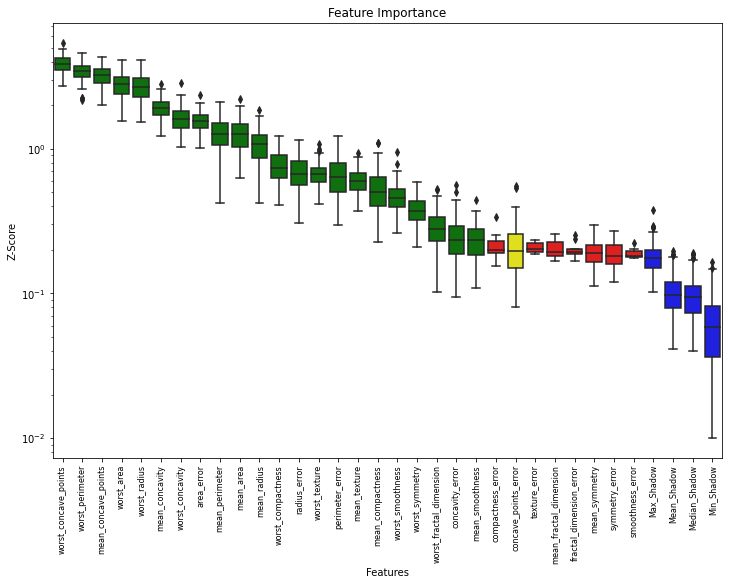

,worst_smoothness,mean_concavity,mean_compactness,worst_concavity,perimeter_error,mean_concave_points,worst_fractal_dimension,radius_error,worst_symmetry,worst_perimeter,...,mean_texture,area_error,worst_radius,worst_concave_points,concavity_error,mean_area,mean_perimeter,worst_area,mean_smoothness,worst_texture
0,0.1622,0.3001,0.27760,0.7119,8.589,0.14710,0.11890,1.0950,0.4601,184.60,...,10.38,153.40,25.38,0.2654,0.05373,1001.0,122.80,2019.0,0.11840,17.33
1,0.1238,0.0869,0.07864,0.2416,3.398,0.07017,0.08902,0.5435,0.2750,158.80,...,17.77,74.08,24.99,0.1860,0.01860,1326.0,132.90,1956.0,0.08474,23.41
2,0.1444,0.1974,0.15990,0.4504,4.585,0.12790,0.08758,0.7456,0.3613,152.50,...,21.25,94.03,23.57,0.2430,0.03832,1203.0,130.00,1709.0,0.10960,25.53
3,0.2098,0.2414,0.28390,0.6869,3.445,0.10520,0.17300,0.4956,0.6638,98.87,...,20.38,27.23,14.91,0.2575,0.05661,386.1,77.58,567.7,0.14250,26.50
4,0.1374,0.1980,0.13280,0.4000,5.438,0.10430,0.07678,0.7572,0.2364,152.20,...,14.34,94.44,22.54,0.1625,0.05688,1297.0,135.10,1575.0,0.10030,16.67


In [23]:
#@title **BrutaSharp**

FEATURES = df.columns[:-1]
TARGET = df.columns[-1]
X = df.loc[:, FEATURES]
y = df.loc[:, TARGET]

if dataset_type == 'Regression':
  Feature_Selector = BorutaShap(importance_measure='shap', classification=False)
else:
  Feature_Selector = BorutaShap(importance_measure='shap', classification=True)

Feature_Selector.fit(X=X, y=y, n_trials=100, sample=False,
            	     train_or_test = 'test', normalize=True,
		     verbose=True)

# Returns Boxplot of features
Feature_Selector.plot(which_features='all')

# Returns a subset of the original data with the selected features
subset = Feature_Selector.Subset()
subset.head()

<details><summary>特徴量選択前後 スコア比較について</summary><div>

「①すべての特徴量を使った場合」と「②特徴量を絞った場合」でモデルのスコア比較を行うものです。RandamForestにて比較し、特徴量選択の適切性を確認します。

In [24]:
#@title **特徴量選択前後 スコア比較_RandomForest**
# 全部の特徴量で学習
if len(str(y[0:])) > 1:
  rf = RandomForestRegressor(n_jobs=-1, max_depth=5)
else:
  rf = RandomForestClassifier(n_jobs=-1, max_depth=5)

rf.fit(X, y)

# 選択した特徴量で学習
if len(str(y[0:])) > 1:
  rf_final = RandomForestRegressor(n_jobs=-1, max_depth=5)
else:
  rf_final = RandomForestClassifier(n_jobs=-1, max_depth=5)

rf_final.fit(subset, y)
print('-----------------------------------------------------------------------------------------')
print('SCORE with All Features: %1.3f' % rf.score(X, y))
print('-----------------------------------------------------------------------------------------')
print('SCORE with subset Features: %1.3f' % rf_final.score(subset, y))
print('-----------------------------------------------------------------------------------------')

rf0=rf.score(X, y)
rf1=rf_final.score(subset, y)
rf0=round(rf0,3)
rf1=round(rf1,3)

-----------------------------------------------------------------------------------------
SCORE with All Features: 0.966
-----------------------------------------------------------------------------------------
SCORE with subset Features: 0.967
-----------------------------------------------------------------------------------------


### **Desision Tree**
<details><summary>Decision tree について</summary><div>
決定木はシンプルなほど解釈しやすくなりますので、まずは可読性を重視した決定木を出力するようにしています。（木の深さは2～6に任意設定できます）

※以下、Noteではデータを訓練用とテスト用に分割し、パラメーターチューニングにより最適化を図った条件で描いたDesicionTreeも表示させるようにしています。

*   #orientation='LR' の # を消すと、決定木の表示は横向きになります。
*   予測したいXの値を X=[X1,X2,X3,X4,…] とすると予測値が表示されます。

In [25]:
#@title **Max_depth**：決定木の深さ設定（2～6） { run: "auto" }
max_depth = 3 #@param {type:"slider", min:2, max:6, step:1}


     |████████████████████████████████| 61 kB 169 kB/s 


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


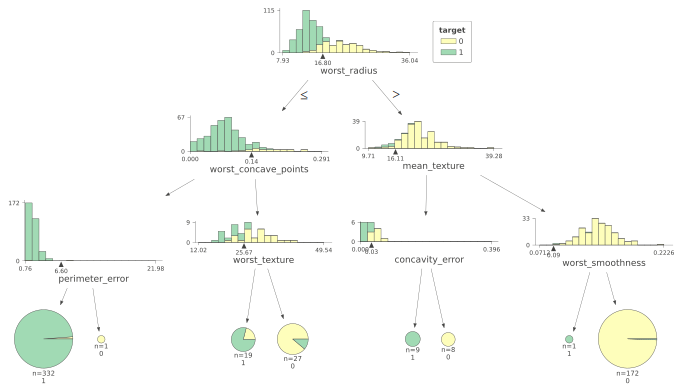

In [26]:
#@title **Desicion tree 表示**

FEATURES = subset.columns
TARGET = df.columns[-1]
X = subset.loc[:, FEATURES]
y = df.loc[:, TARGET]


!pip install dtreeviz --quiet
from dtreeviz.trees import *

if dataset_type == 'Classification':
  CLASS_NAME = list(y.unique())
  dtree = tree.DecisionTreeClassifier(max_depth=max_depth)
  dtree.fit(subset,y)
  viz = dtreeviz(dtree,subset,y,
               target_name = TARGET,
               feature_names = FEATURES,
               #orientation='LR',
               class_names = CLASS_NAME,
               #X = [3,3,3,5,3]
              )

if dataset_type == 'Regression':
  dtree = tree.DecisionTreeRegressor(max_depth=max_depth)
  dtree.fit(subset,y)
  viz = dtreeviz(dtree,subset,y,
               target_name = TARGET,
               feature_names = FEATURES,
               #orientation='LR',
               #X = [3,3,5,3]
              )

viz

DecisionTreeClassifier(max_depth=4, min_samples_leaf=3, random_state=0)


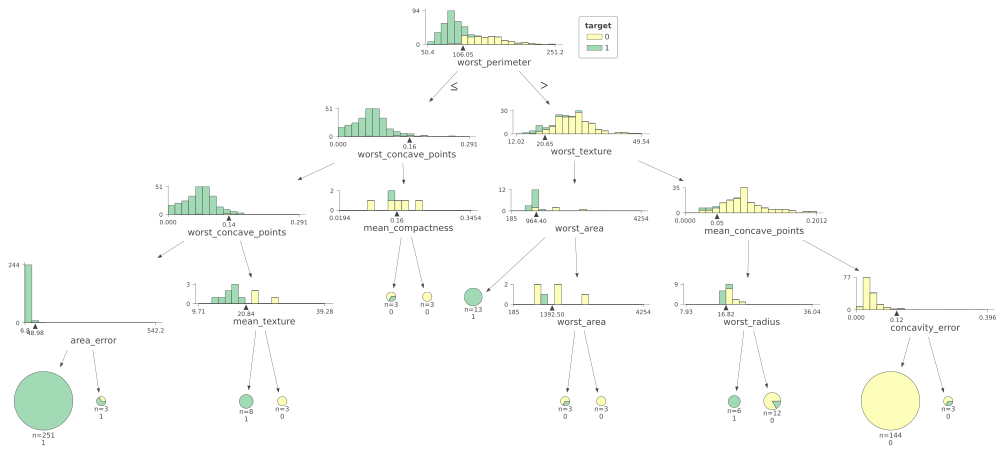

In [27]:
#@title **DecisionTree表示（GridSearchによるパラメータ最適化Ver.）**

#testとtrainを分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(subset, y, test_size = 0.20, random_state = 1)

#ライブラリインポート
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

#GridSearch実行
if dataset_type == 'Classification':
  dtr = DecisionTreeClassifier(random_state=0)

else:
  dtr = DecisionTreeRegressor(random_state=0)

gs_dtr = GridSearchCV(dtr,
                      param_grid = {'max_depth': [1, 2, 3, 4, 5, 6, 7],
                      'min_samples_leaf':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
                      cv = 10)

gs_dtr.fit(X_train, y_train)

#パラメータ最適化 ⇒ DecisionTree出力
if dataset_type == 'Classification':
  viz = dtreeviz(gs_dtr.best_estimator_,
               X_train,
               y_train,
               target_name = TARGET,
               feature_names = FEATURES,
               #orientation='LR',
               #X = [3,3,5,3],
               class_names = list(y.unique())
              )

else:
  viz = dtreeviz(gs_dtr.best_estimator_,
               X_train,
               y_train,
               target_name = TARGET,
               feature_names = FEATURES,
               #orientation='LR',
               #X = [3,3,5,3]
              )
print(gs_dtr.best_estimator_)
viz

In [28]:
#@title **Decision tree 画像出力（☑ ＝実行）**  { run: "auto" }
Decision_tree_output = False #@param {type:"boolean"}

if Decision_tree_output == True:
  viz.save('Decission_tree_result.svg')

Decision_tree_best_output = False #@param {type:"boolean"}

if Decision_tree_best_output == True:
  viz.save('Decission_tree_best_result.svg')

### **Appendix：Display on Plotly**

In [29]:
#@title **Display feature importrance on Plotly**

Display_feature_importance = False #@param {type:"boolean"}

#feature importanceグラフ表示
import plotly.express as px

Feature_Selector.results_to_csv(filename='feature_importance')
df_ = pd.read_csv('feature_importance.csv')
fig = px.scatter(df_, x="Features", y='Average Feature Importance', color='Decision',symbol='Decision',
    #width=600, height=500, 
    opacity=0.75, 
    title="Feature selected result")
fig = fig.update_yaxes(scaleanchor="x", scaleratio=2)
fig = fig.update_traces(marker=dict(size=10,
    line=dict(width=0.4, color="Black")))

#Display not/go
if Display_feature_importance == True:
  fig.show()

     |████████████████████████████████| 898 kB 5.8 MB/s 
     |████████████████████████████████| 2.7 MB 40.7 MB/s 
Reading package lists...
Building dependency tree...
Reading state information...
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 67 not upgraded.
Need to get 154 kB of archives.
After this operation, 613 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 poppler-utils amd64 0.62.0-2ubuntu2.12 [154 kB]
Fetched 154 kB in 1s (227 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 155203 files and directories currently installed.)
Preparing to unpack .../poppler-utils_0.62.0-2ubuntu2.12_amd64.deb ...
Unpacking poppler-utils (0.62.0-2ubuntu2.12) ...
Setting up poppler-u


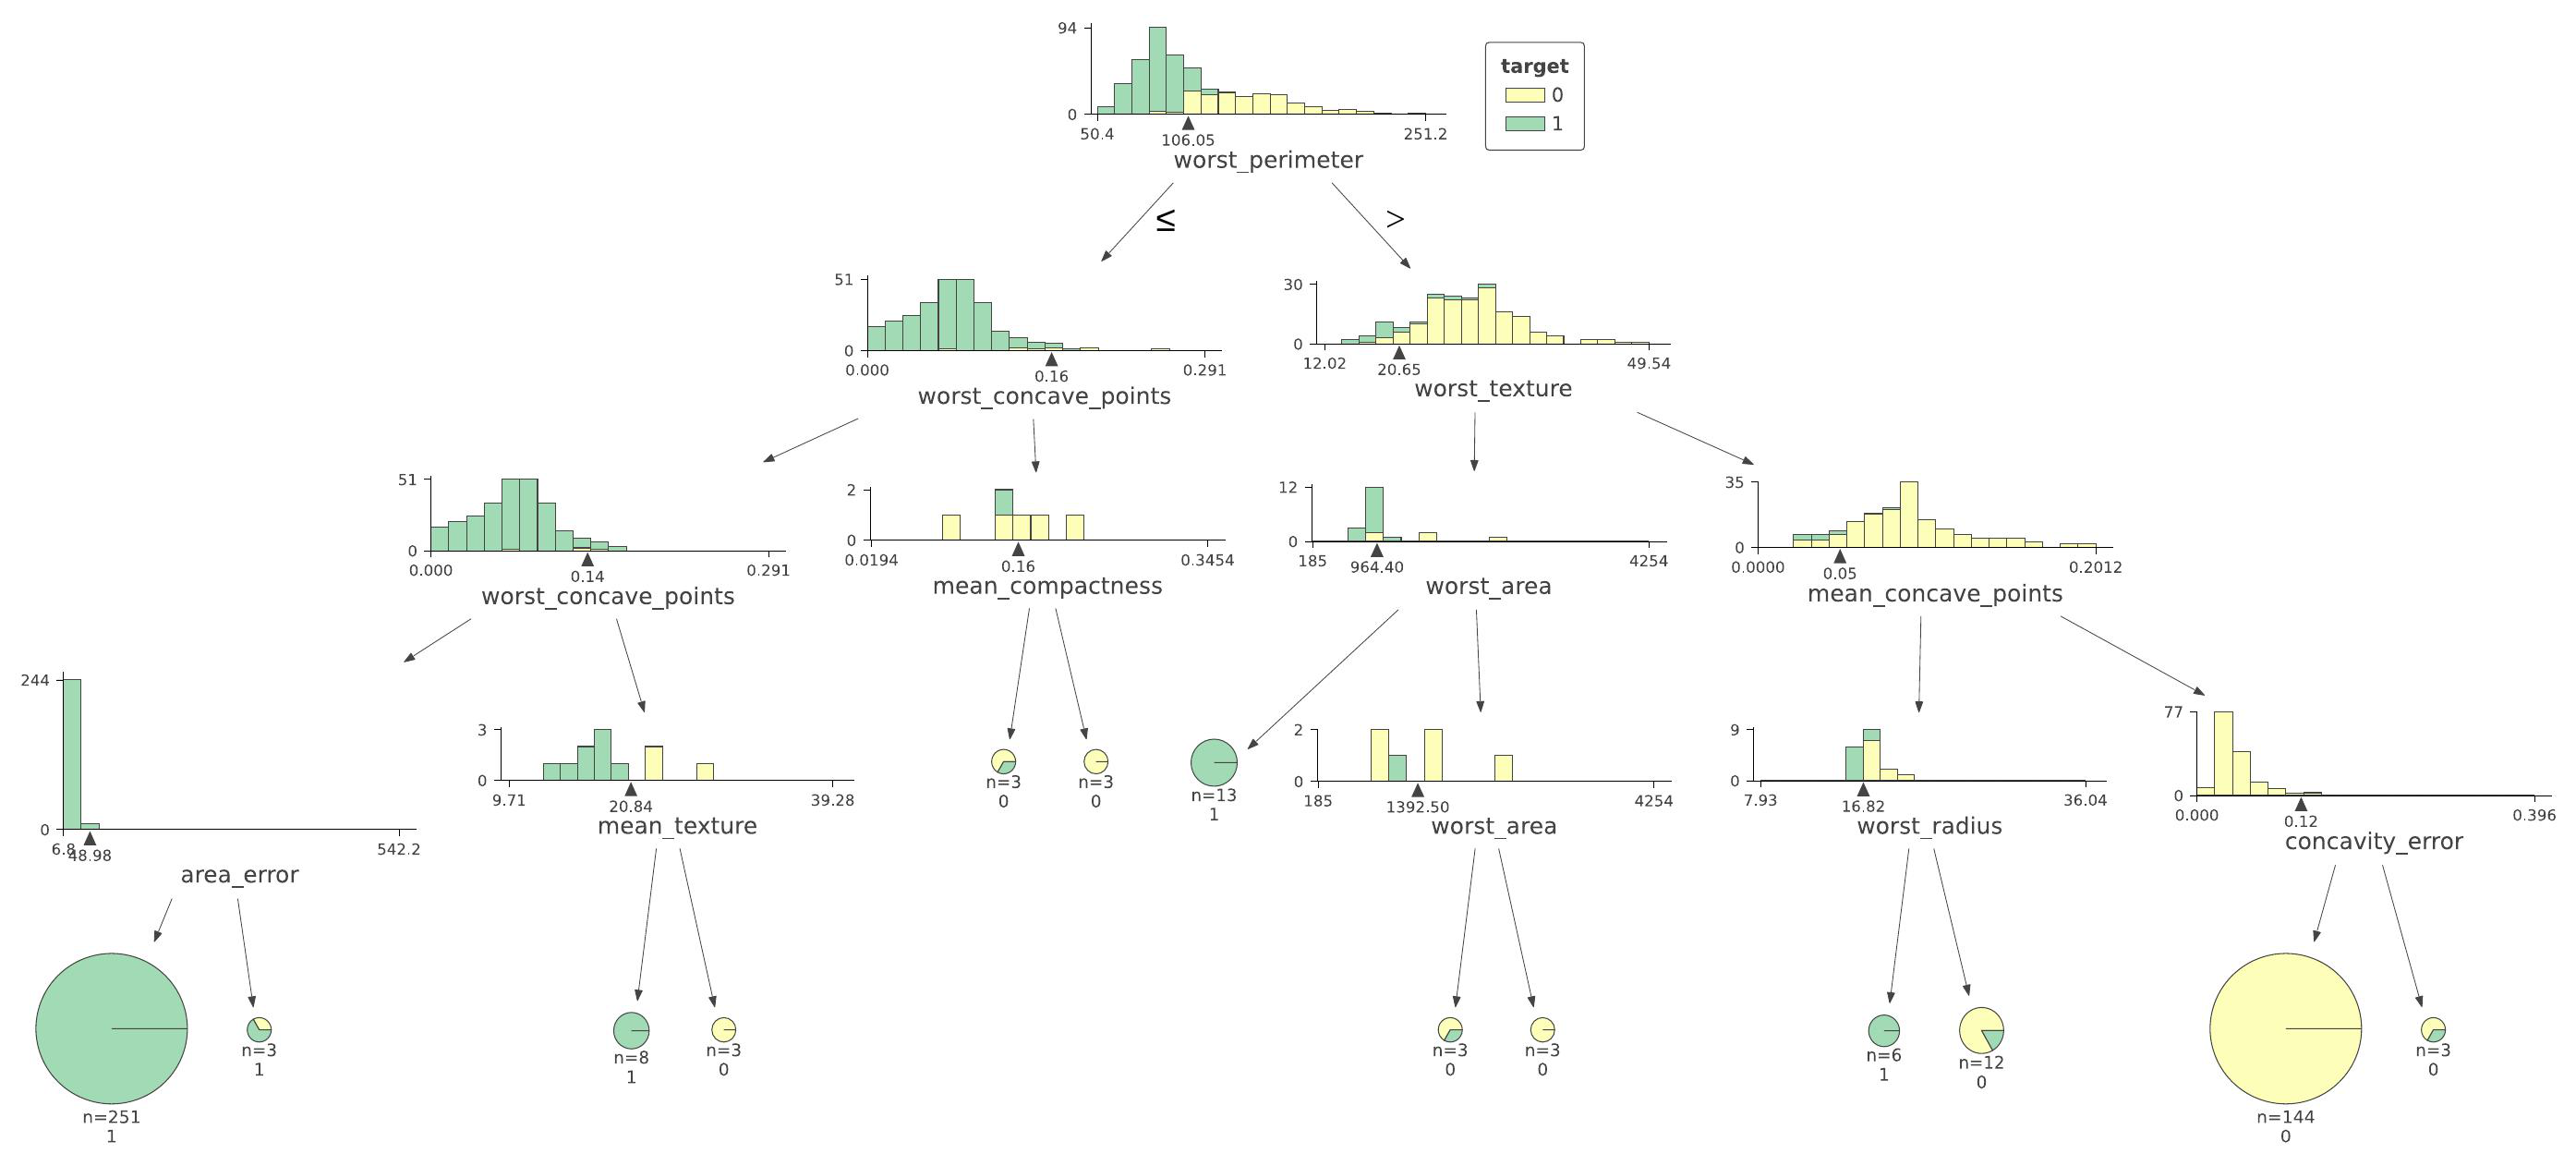

In [30]:
#@title **Preparation_image conversion**
!pip install svglib --quiet
!apt-get install poppler-utils --quiet
!pip install pdf2image --quiet

from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF, renderPM

#dtreeviz_svg ‐> pdf
viz.save('Decission_tree_best_result.svg')
drawing = svg2rlg("Decission_tree_best_result.svg")
renderPDF.drawToFile(drawing, "Decission_tree_result.pdf")

#dtreeviz_pdf -> jpeg
import subprocess
subprocess.Popen(['Decission_tree_result.pdf'],shell=True)

from pdf2image import convert_from_path
images = convert_from_path("Decission_tree_result.pdf")

#images[0] 
for i in range(len(images)):
    images[i].save('Decission_tree_result'+'.jpg', 'JPEG')

#Display decision tree on plotly
import plotly.express as px
from skimage import io
img = io.imread('Decission_tree_result.jpg')
fig = px.imshow(img)
fig.update_layout(height=800,width=None)
#fig.show()

In [31]:
#@title **Display decision tree on Plotly**

Display_decision_tree = False #@param {type:"boolean"}

import plotly.express as px
from skimage import io
img = io.imread('Decission_tree_result.jpg')
fig = px.imshow(img)
fig.update_layout(height=800,width=None)

#Display not/go
if Display_decision_tree == True:
  fig.show()

## **Dashboard**
<details><summary>click on the URL to launch dashboard (see below)</summary><div>

In [32]:
#@title **Dash app run**

#Dash表示グラフ作成
import plotly.graph_objects as go
#from plotly.subplots import make_subplots  #サブプロット

#特徴量選択後のデータセット
subset_ = pd.concat([subset, y], axis=1)

#graph
fig = px.scatter(df_, x="Features", y='Average Feature Importance',
                 color='Decision',symbol='Decision', opacity=0.75, title="Feature selected result")
fig = fig.update_yaxes(scaleanchor="x", scaleratio=2)
fig = fig.update_traces(marker=dict(size=12, line=dict(width=0.4, color="Black")))
fig = go.Figure(fig)

from skimage import io
img = io.imread('Decission_tree_result.jpg')
fig2 = px.imshow(img)
fig2.update_layout(height=800,width=None)


#app = dash.Dash()
app = JupyterDash(__name__)

app.layout = html.Div([
    dcc.Markdown('''
    ![Dash](https://plotly-marketing-website.cdn.prismic.io/plotly-marketing-website/948b6663-9429-4bd6-a4cc-cb33231d4532_logo-plotly.svg "Dash")
            '''),
    html.H1('Dataset Summary Report', style={"textAlign":"center"}),
    dcc.Markdown('''
    ***
    - **レポート内容**　：目的変数と特徴量の関係を把握をできるだけ簡単にするため、データセットから重要な特徴量だけを選択し、目的変数と特徴量の関係をデシジョンツリーに出力している。

    - **分析ステップ**　：対象データセット（**Dataset**） ⇒ 前処理 ⇒ 特徴量選択 ⇒ 前処理後のデータセット（**Dataset after preprocessing**） ⇒ 特徴量重要度グラフ表示（**Feature importance**） ⇒ 目的変数－特徴量の関係をデシジョンツリー表示（**Decision tree**）
    ***
        '''),
    html.H2('■ Dataset'),
    html.P('- Dataset type：{}'.format(dataset_type)),
    dcc.Markdown('''
    ※以下は元データ。カラム毎のソートやフィルタリングが可能。
        '''),
    dash_table.DataTable(
        style_cell={"textAlign":"center","width":"120px"},
        fill_width=False,
        fixed_rows={"headers":True},
        page_size=10,
        filter_action='native',
        sort_action='native',
        columns=[{"name":col, "id":col} for col in source.columns],
        data=source.to_dict('records')
    ),
    html.P('- Number of data：{} data'.format(len(df))),
    html.P('- Number of columns：{} columns'.format(len(df.columns))),
#    html.P('Columns：{}'.format(df.columns)),
    dcc.Markdown('''
    ***
        '''),
    html.H2('■ Dataset after preprocessing'),
    dcc.Markdown('''
    ※以下は前処理後データ。カラム毎のソートやフィルタリングが可能。
        '''),
    dash_table.DataTable(
        style_cell={"textAlign":"center","width":"120px"},
        fill_width=False,
        fixed_rows={"headers":True},
        page_size=10,
        filter_action='native',
        sort_action='native',
        columns=[{"name":col, "id":col} for col in subset_.columns],
        data=subset_.to_dict('records')
    ),
    html.P('- Number of data：{} data'.format(len(subset_))),
    html.P('- Number of columns：{} columns'.format(len(subset_.columns))),
#    html.P('Columns：{}'.format(subset_.columns)),
    dcc.Markdown('''
    
    ***
        '''),
    html.H2('■ Feature importance'),
    dcc.Markdown('''
    ※特徴量を重要度順に表示。（**Accepted**＝選択された特徴量｜**Rejected**＝削除された特徴量｜**Shadow**は学習で適用された項目＝無視）
        '''),
    dcc.Graph(id='example-graph',figure=fig,
              #style={'width':'60%'}
              ),
    html.P('- Score with All features: {}'.format(rf0)),
    html.P('- Score after feature selection: {}'.format(rf1)),
    dcc.Markdown('''
    ※特徴量選択前後のRandomForestによるスコア比較
    ***
    
        '''),
    html.H2('■ Desicion tree'),
    dcc.Markdown('''
    ※重要度の高い特徴量によるデシジョンツリー。（ズームイン・ズームアウト可能）
        '''),
    dcc.Graph(id='graph',figure=fig2,
              #style={'width':'60%'}
              ),
    dcc.Markdown('''
    
    ***
    **Note**
    - 前処理は、ID等のカラム削除、欠損値処理、デシジョンツリー分析を前提としたデータのエンコーディング等、割り切った内容としている。

    - 分析結果があてになるかは、特徴量選択前後のスコア（機械学習の結果）がひとつの材料。（スコアが高く、前後のスコア差が小さい場合はよい）

    - Link  ：[特徴量選択](https://pypi.org/project/BorutaShap/)｜[デシジョンツリー](https://github.com/parrt/dtreeviz)｜[グラフ](https://github.com/plotly/plotly_express)｜[ダッシュボード](https://github.com/plotly/dash)
    ***
        '''),
    dcc.Markdown('''
    ![Dash](https://gitlab.com/uploads/-/system/project/avatar/12244643/8f93410dee98ff6b9439a603ee22998ed282ecae_dash-logo-by-plotly-stripe-inverted3x.png?width=64 "Dash")
            '''),
#    html.H3('May,2022', style={"textAlign":"right"}),

])

if __name__ =='__main__':  
#    app.run_server(mode='inline')
    app.run_server(mode='external')

Dash app running on:


<IPython.core.display.Javascript object>